In [97]:
### import statements 
import obonet
from itertools import combinations 
from Bio import Medline
import networkx as nx
import string
from textblob import TextBlob  

import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd

import seaborn as sns

from networkx.algorithms import tree

In [98]:
# experiment configurations
MAX_NUMBER_BIGRAMS = 30
MAX_NUMBER_PUBLICATION = 1200

In [99]:
# parsing a medline file 
def parse_medline_rmap(medline_file):    
    map_abstracts = {}    
    pmid = ''
    abstract = ''  
    with open(medline_file) as medline_handle:
        records = Medline.parse(medline_handle)
        for record in records:         
            keys = record.keys()            
            if 'PMID' in keys and 'AB' in keys: 

                pmid = record['PMID']
                abstract = record['AB']
                
                map_abstracts[pmid] = abstract.lower()
    return map_abstracts  

In [100]:
def parse_chatGPT(chatGPTabstracts):
    count = 0
    map_abs = {}  
    read_handle = open(chatGPTabstracts)
    lines = read_handle.readlines()
    for line in lines:
        if len(line) > 1 and line.startswith('Abstract'):
            map_abs[count] = line
            count += 1
            # print(line[:100])
    return map_abs

In [101]:
def remove_string_special_characters(s):
      
    # removes special characters with ' '
    stripped = re.sub('[^a-zA-z\s]', '', s)
    stripped = re.sub('_', '', stripped)
      
    # Change any white space to one space
    stripped = re.sub('\s+', ' ', stripped)
      
    # Remove start and end white spaces
    stripped = stripped.strip()
    if stripped != '':
            return stripped.lower()

In [102]:
pubmed_abstracts = parse_medline_rmap('pubmed-alzheimers-set.txt')
cgpt_abstracts = parse_chatGPT('chaptGPTpubs.txt')

# cleaning PubMed articles from special characters
clean_pubmed_training = []
for abst in list(pubmed_abstracts.values())[0:]:
    cleaned = remove_string_special_characters(abst)    
    clean_pubmed_training.append(cleaned)
    
# cleaning chatGPT articles from special characters
clean_chatGPT_training = []
for abst in list(cgpt_abstracts.values())[0:]:
    cleaned = remove_string_special_characters(abst)    
    clean_chatGPT_training.append(cleaned)    
    
    
    

In [103]:
stop_words = set(stopwords.words('english'))
special_list = ['abstract']


def stopwords_rem_pubmed(clean_pubmed_training):
    stopped_pubmed_training = []
    for abst in clean_pubmed_training[:MAX_NUMBER_PUBLICATION]:
        valid_l = []
        valid_rec = []
        blob_object = TextBlob(abst)
        list_tokens = blob_object.words

        for token in list_tokens:        
            if token not in stop_words:
                valid_l.append(token)            
        valid_rec = ' '.join(valid_l)
        stopped_pubmed_training.append(valid_rec)
    return stopped_pubmed_training
    
    
def stopwords_rem_chatGPT(clean_chatGPT_training):    
    stopped_chatGPT_training = []
    for abst in clean_chatGPT_training[:MAX_NUMBER_PUBLICATION]:
        valid_l = []
        valid_rec = []
        blob_object = TextBlob(abst)
        list_tokens = blob_object.words

        for token in list_tokens:        
            if (token not in stop_words) and (token not in special_list):
                valid_l.append(token)            
        valid_rec = ' '.join(valid_l)
        stopped_chatGPT_training.append(valid_rec)   
    return stopped_chatGPT_training

In [104]:
stopped_pubmed_training = stopwords_rem_pubmed(clean_pubmed_training)
stopped_chatGPT_test = stopwords_rem_chatGPT(clean_chatGPT_training)

In [105]:
# for art in stopped_pubmed_training[:3]:
#     print(art)
#     print('------')

# print('=========')    
# for art in stopped_chatGPT_test[:3]:
#     print(art)
#     print('------')    


In [106]:
# Getting PubMed bigrams
def compute_pubmed_bigrams(stopped_pubmed_training):
    list_bigrams = []

    vectorizer = CountVectorizer(ngram_range =(2, 2))
    X1 = vectorizer.fit_transform(stopped_pubmed_training)
    features = (vectorizer.get_feature_names_out())
    # print("\n\nX1 : \n", X1.toarray())

    # Applying TFIDF
    # You can still get n-grams here
    vectorizer = TfidfVectorizer(ngram_range = (2, 2))
    X2 = vectorizer.fit_transform(stopped_pubmed_training)
    scores = (X2.toarray())
    # print("\n\nScores : \n", scores)

    # Getting top ranking features
    sums = X2.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
    words = (ranking.sort_values('rank', ascending = False))

    bigram_ranks = {}
    for index, row in words.iterrows():
        # print(row['term'],'\t\t\t',  row['rank'])

        splits = row['term'].split()
        bigram_ranks[row['rank']] = (splits[0], splits[1])

    count = 0    
    for k, v in bigram_ranks.items():
        if count < MAX_NUMBER_BIGRAMS:
            # print(k,'\t',  v)
            count += 1
        list_bigrams.append(v)
    return bigram_ranks    

In [107]:
# Getting chatGPT bigrams
def compute_chatGPT_bigrams(stopped_chatGPT_test):
    list_bigrams = []

    vectorizer = CountVectorizer(ngram_range =(2, 2))
    X1 = vectorizer.fit_transform(stopped_chatGPT_test)
    features = (vectorizer.get_feature_names_out())

    # Applying TFIDF
    # You can still get n-grams here
    vectorizer = TfidfVectorizer(ngram_range = (2, 2))
    X2 = vectorizer.fit_transform(stopped_chatGPT_test)
    scores = (X2.toarray())
    # print("\n\nScores : \n", scores)

    # Getting top ranking features
    sums = X2.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
    words = (ranking.sort_values('rank', ascending = False))

    bigram_ranks = {}
    for index, row in words.iterrows():
        splits = row['term'].split()
        bigram_ranks[row['rank']] = (splits[0], splits[1])

    count = 0    
    for k, v in bigram_ranks.items():
        if count < MAX_NUMBER_BIGRAMS:
            count += 1
        list_bigrams.append(v)
    return bigram_ranks 

In [108]:
pubmed_bigrams_map = compute_pubmed_bigrams(stopped_pubmed_training[:100])
print(len(pubmed_bigrams_map))

pubmed_bigrams_map_tst1 = compute_pubmed_bigrams(stopped_pubmed_training[100:200])
print(len(pubmed_bigrams_map_tst1))

pubmed_bigrams_map_tst2 = compute_pubmed_bigrams(stopped_pubmed_training[200:300])
print(len(pubmed_bigrams_map_tst2))

pubmed_bigrams_map_tst3 = compute_pubmed_bigrams(stopped_pubmed_training[300:400])
print(len(pubmed_bigrams_map_tst3))

pubmed_bigrams_map_tst4 = compute_pubmed_bigrams(stopped_pubmed_training[400:500])
print(len(pubmed_bigrams_map_tst4))

pubmed_bigrams_map_tst5 = compute_pubmed_bigrams(stopped_pubmed_training[500:600])
print(len(pubmed_bigrams_map_tst5))

pubmed_bigrams_map_tst6 = compute_pubmed_bigrams(stopped_pubmed_training[600:700])
print(len(pubmed_bigrams_map_tst6))

pubmed_bigrams_map_tst7 = compute_pubmed_bigrams(stopped_pubmed_training[700:800])
print(len(pubmed_bigrams_map_tst7))

pubmed_bigrams_map_tst8 = compute_pubmed_bigrams(stopped_pubmed_training[800:900])
print(len(pubmed_bigrams_map_tst8))

pubmed_bigrams_map_tst9 = compute_pubmed_bigrams(stopped_pubmed_training[900:1000])
print(len(pubmed_bigrams_map_tst9))

pubmed_bigrams_map_tst10 = compute_pubmed_bigrams(stopped_pubmed_training[1000:1100])
print(len(pubmed_bigrams_map_tst10))


920
966
947
809
887
848
944
918
892
902
878


In [109]:
chatGPT_bigrams_map = compute_chatGPT_bigrams(stopped_chatGPT_test)
len(chatGPT_bigrams_map)

516

[3.294679569040423,
 1.7213267129332457,
 1.5841411184179468,
 1.3303872362121771,
 1.1814432744810128,
 0.9182158688447168,
 0.8904821226304852,
 0.8713016955577485,
 0.8336620491967368,
 0.8291688018744692]

In [172]:
number_of_overlapping_edges = 0

t_weights = pubmed_bigrams_map.keys()
t_bigrams = pubmed_bigrams_map.values()


# for pubmed_bigram in pubmed_bigrams_map.values():
#     for chatGPT_bigram in chatGPT_bigrams_map.values():
#         if (pubmed_bigram[0] == chatGPT_bigram[0]) and (pubmed_bigram[1] == chatGPT_bigram[1]):
#             number_of_overlapping_edges += 1
# print("Number of overlapping edges: ", number_of_overlapping_edges)            
# print("Percent of ChatGPT to self:    ", number_of_overlapping_edges/len(chatGPT_bigrams_map)) 
# print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

training_data = {'DataSource': 'Training', 
                'Bigrams': len(t_bigrams), 
                'Percent%': 1, 
                'Similarity': 1           
       }

In [174]:
training_bigrams = list(t_bigrams)[0:20]
training_weights = list(t_weights)[0:20]
print(training_bigrams)
print(training_weights)

[('alzheimers', 'disease'), ('disease', 'ad'), ('ad', 'patients'), ('cognitive', 'impairment'), ('risk', 'factors'), ('patients', 'alzheimers'), ('ad', 'dementia'), ('people', 'ad'), ('diabetes', 'mellitus'), ('vascular', 'dementia'), ('without', 'ad'), ('patients', 'ad'), ('cognitive', 'decline'), ('clinical', 'trials'), ('dementia', 'alzheimers'), ('cerebrovascular', 'disease'), ('associated', 'ad'), ('health', 'care'), ('economic', 'burden'), ('macular', 'degeneration')]
[3.294679569040423, 1.7213267129332457, 1.5841411184179468, 1.3303872362121771, 1.1814432744810128, 0.9182158688447168, 0.8904821226304852, 0.8713016955577485, 0.8336620491967368, 0.8291688018744692, 0.7824722460763167, 0.7585418766835189, 0.7568735732453263, 0.7516205854141419, 0.7395957047608518, 0.6636656481113307, 0.6274091798815155, 0.6098235077262026, 0.6053020600037131, 0.5892556256203044]


In [125]:
# pip install wordcloud

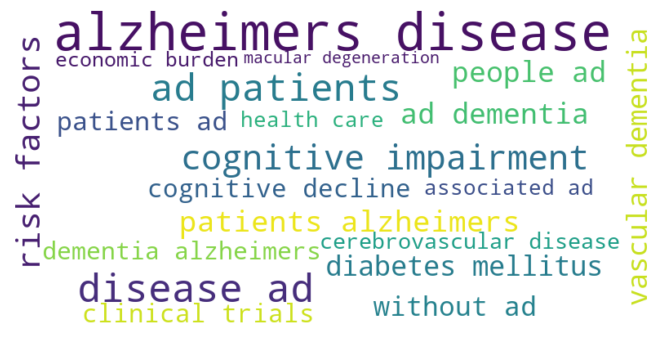

In [183]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

bigrams = training_bigrams
weights = training_weights

# create a dictionary of bigram weights
bigram_weights = dict(zip([' '.join(bigram) for bigram in bigrams], weights))

# create a word cloud from the bigram weights
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_weights)

# save the word cloud to a file
wordcloud.to_file('training_bigrams_wordcloud.png')

# display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [130]:
# Calibrating against PubMed tst1
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst1_bigram in pubmed_bigrams_map_tst1.values():
        if (pubmed_bigram[0] == tst1_bigram[0]) and (pubmed_bigram[1] == tst1_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst1)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 


tst1 = {'DataSource': 'Fold-1','Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst1)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))           
       }

Number of overlapping edges:  202
Percent to self:     0.20910973084886128
Percent of main graph contribution:  0.21956521739130436


In [33]:
# Calibrating against PubMed tst2
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst2_bigram in pubmed_bigrams_map_tst2.values():
        if (pubmed_bigram[0] == tst2_bigram[0]) and (pubmed_bigram[1] == tst2_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst2)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

tst2 = {'DataSource': 'Fold-2','Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst2)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))           
       }

Number of overlapping edges:  183
Percent to self:     0.1932418162618796
Percent of main graph contribution:  0.19891304347826086


In [34]:
# Calibrating against PubMed tst3
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst3_bigram in pubmed_bigrams_map_tst3.values():
        if (pubmed_bigram[0] == tst3_bigram[0]) and (pubmed_bigram[1] == tst3_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst3)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

tst3 = {'DataSource': 'Fold-3','Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst3)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))           
       }


Number of overlapping edges:  178
Percent to self:     0.2200247218788628
Percent of main graph contribution:  0.1934782608695652


In [35]:
# Calibrating against PubMed tst4
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst4_bigram in pubmed_bigrams_map_tst4.values():
        if (pubmed_bigram[0] == tst4_bigram[0]) and (pubmed_bigram[1] == tst4_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent%:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst4)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 


tst4 = {'DataSource': 'Fold-4','Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst4)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))           
       }

Number of overlapping edges:  178
Percent%:     0.20067643742953778
Percent of main graph contribution:  0.1934782608695652


In [36]:
# Calibrating against PubMed tst5
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst5_bigram in pubmed_bigrams_map_tst5.values():
        if (pubmed_bigram[0] == tst5_bigram[0]) and (pubmed_bigram[1] == tst5_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst5)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

tst5 = {'DataSource': 'Fold-5', 'Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst5)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))           
       }


Number of overlapping edges:  180
Percent to self:     0.21226415094339623
Percent of main graph contribution:  0.1956521739130435


In [37]:
# Calibrating against PubMed tst6
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst6_bigram in pubmed_bigrams_map_tst6.values():
        if (pubmed_bigram[0] == tst6_bigram[0]) and (pubmed_bigram[1] == tst6_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst6)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

tst6 = {'DataSource': 'Fold-6', 'Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst6)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))           
       }

Number of overlapping edges:  180
Percent to self:     0.1906779661016949
Percent of main graph contribution:  0.1956521739130435


In [38]:
# Calibrating against PubMed tst7
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst7_bigram in pubmed_bigrams_map_tst7.values():
        if (pubmed_bigram[0] == tst7_bigram[0]) and (pubmed_bigram[1] == tst7_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst7)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

tst7 = {'DataSource': 'Fold-7', 'Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst7)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))           
       }

Number of overlapping edges:  179
Percent to self:     0.19498910675381265
Percent of main graph contribution:  0.19456521739130433


In [39]:
# Calibrating against PubMed tst8
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst8_bigram in pubmed_bigrams_map_tst8.values():
        if (pubmed_bigram[0] == tst8_bigram[0]) and (pubmed_bigram[1] == tst8_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst8)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

tst8 = {'DataSource': 'Fold-8', 'Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst8)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))           
       }

Number of overlapping edges:  181
Percent to self:     0.20291479820627803
Percent of main graph contribution:  0.1967391304347826


In [40]:
# Calibrating against PubMed tst9
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst9_bigram in pubmed_bigrams_map_tst9.values():
        if (pubmed_bigram[0] == tst9_bigram[0]) and (pubmed_bigram[1] == tst9_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst9)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

tst9 = {'DataSource': 'Fold-9', 'Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst9)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))          
       }

Number of overlapping edges:  184
Percent to self:     0.2039911308203991
Percent of main graph contribution:  0.2


In [41]:
# Calibrating against PubMed tst10
number_of_overlapping_edges = 0
for pubmed_bigram in pubmed_bigrams_map.values():
    for tst10_bigram in pubmed_bigrams_map_tst10.values():
        if (pubmed_bigram[0] == tst10_bigram[0]) and (pubmed_bigram[1] == tst10_bigram[1]):
            number_of_overlapping_edges += 1
print("Number of overlapping edges: ", number_of_overlapping_edges)            
print("Percent to self:    ", number_of_overlapping_edges/len(pubmed_bigrams_map_tst10)) 
print("Percent of main graph contribution: ", number_of_overlapping_edges/len(pubmed_bigrams_map)) 

tst10 = {'DataSource': 'Fold-10', 'Bigrams': number_of_overlapping_edges, 
        'Percent%': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map_tst10)), 
        'Similarity': "{:.2f}".format(number_of_overlapping_edges/len(pubmed_bigrams_map))          
       }

Number of overlapping edges:  201
Percent to self:     0.22892938496583143
Percent of main graph contribution:  0.2184782608695652


In [177]:
chatGPT_bigrams = list(chatGPT_bigrams_map.values())[0:20]
chatGPT_weights = list(chatGPT_bigrams_map.keys())[:20]

print(chatGPT_bigrams)
print('----')
print(chatGPT_weights)

[('ad', 'patients'), ('cognitive', 'impairment'), ('older', 'adults'), ('alzheimers', 'disease'), ('increased', 'risk'), ('associated', 'increased'), ('sleep', 'disorders'), ('disease', 'ad'), ('ad', 'comorbidities'), ('results', 'showed'), ('common', 'comorbidity'), ('suggested', 'associated'), ('cognitive', 'function'), ('systematic', 'review'), ('risk', 'ad'), ('ad', 'results'), ('adults', 'suggested'), ('impairment', 'dementia'), ('review', 'metaanalysis'), ('prevent', 'delay')]
----
[5.877666957166765, 5.446640621810559, 5.009706424410766, 4.558333417734028, 4.131099283949768, 4.059549125834358, 4.044556399450758, 3.981037900145317, 3.9803365750491504, 3.6853660290922474, 3.5713646918488435, 3.419235591516531, 3.263712005642625, 3.1831514101198963, 3.1559473320808737, 3.123473107684331, 3.1066474016423746, 3.030046170974259, 2.9222935037329436, 2.9126596347570075]


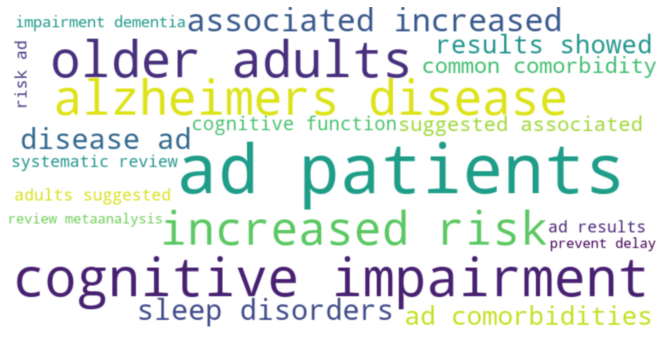

In [184]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

bigrams = chatGPT_bigrams
weights = chatGPT_weights

# create a dictionary of bigram weights
bigram_weights = dict(zip([' '.join(bigram) for bigram in bigrams], weights))

# create a word cloud from the bigram weights
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_weights)

# save the word cloud to a file
wordcloud.to_file('chatGPT_bigrams_wordcloud.png')

# display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis('off')
plt.show()

In [43]:
data = [tst1, tst2, tst3, tst4,tst5,tst6,tst7,tst8,tst9,tst10, chatGPT_data]
df = pd.DataFrame(data)

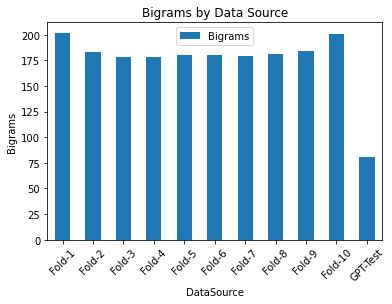

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data
# data = {'Data Source': ['Source 1', 'Source 2', 'Source 3', 'Source 4'],
#         'Bigrams': [100, 80, 120, 90]}

# Create a pandas DataFrame from the data
df = pd.DataFrame(data)

# Set the 'Data Source' column as the index
df.set_index('DataSource', inplace=True)

# Create the bar plot
ax = df.plot(kind='bar', rot=45)

# Set the axis labels and title
ax.set_xlabel('DataSource')
ax.set_ylabel('Bigrams')
ax.set_title('Bigrams by Data Source')

# Save the plot to a file
plt.savefig('bigram-barplot.png', dpi=1000, bbox_inches='tight')

In [45]:
import pandas as pd

# Create a sample DataFrame
# df = pd.DataFrame({'Column 1': [1, 2, 3], 'Column 2': [4, 5, 6]})

# Define a function to add borders to the DataFrame
def add_border(s):
    return 'border: 1px solid black'

# Style the DataFrame and add borders
styled_df = df.style.set_properties(**{'border': '1px solid black', 'border-collapse': 'collapse'})\
    .set_table_styles([{'selector': 'th', 'props': [('border', '1px solid black')]}])\
    .applymap(add_border)

# Display the styled DataFrame
display(styled_df)

,Bigrams,Percent%,Similarity
DataSource,,,
Fold-1,202,0.21,0.22
Fold-2,183,0.19,0.20
Fold-3,178,0.22,0.19
Fold-4,178,0.20,0.19
Fold-5,180,0.21,0.20
Fold-6,180,0.19,0.20
Fold-7,179,0.19,0.19
Fold-8,181,0.20,0.20
Fold-9,184,0.20,0.20


In [46]:
# sns.set(style = 'whitegrid')
# sns.barplot(x ="DataSource", y ="Bigrams", data = df)

In [47]:
# seaborn.scatterplot(data['self'],data['Weight'])

# sns.scatterplot(x ="DataSource", y ="RatioToSelf", data = df)

In [48]:
# sns.swarmplot(x ="DataSource", y='Edges', data = df)

In [49]:
# sns.set(style = 'whitegrid')
# sns.barplot(x ="DataSource", y ="RatioToSelf", data = df)

In [50]:
# sns.set(style = 'whitegrid')
# sns.barplot(x ="DataSource", y ="RatioToTraining", data = df)

In [51]:
# sns.set(style = 'whitegrid')
# sns.pointplot(x ="Edges", y ="RatioToTraining", data = df)

In [52]:
# sns.set(style = 'whitegrid')
# sns.boxplot( df['Edges'], df['RatioToSelf'])

In [53]:
# sns.kdeplot( df['Edges'], df['RatioToSelf'])

In [54]:
# sns.distplot( df['Edges'])

In [55]:
# import matplotlib.pyplot as plt
# sns.histplot(df['Edges'], kde=True)
# plt.show()

In [56]:
# sns.displot(data=df, x="DataSource", col="Edges", kde=True)

In [57]:
# sns.jointplot(data=df, x="DataSource", col="Edges")

In [58]:
# sns.catplot(data=df, kind="violin", x="DataSource", y="Edges", split=True)

In [59]:
pubmed_bigrams_map_training = compute_pubmed_bigrams(stopped_pubmed_training[:100])
print(len(pubmed_bigrams_map_training))

print(list(pubmed_bigrams_map_training.values())[:1])


pubmed_bigrams_map_tst1 = compute_pubmed_bigrams(stopped_pubmed_training[100:200])
print(len(pubmed_bigrams_map_tst1))

pubmed_bigrams_map_tst2 = compute_pubmed_bigrams(stopped_pubmed_training[200:300])
print(len(pubmed_bigrams_map_tst2))

pubmed_bigrams_map_tst3 = compute_pubmed_bigrams(stopped_pubmed_training[300:400])
print(len(pubmed_bigrams_map_tst3))

pubmed_bigrams_map_tst4 = compute_pubmed_bigrams(stopped_pubmed_training[400:500])
print(len(pubmed_bigrams_map_tst4))

pubmed_bigrams_map_tst5 = compute_pubmed_bigrams(stopped_pubmed_training[500:600])
print(len(pubmed_bigrams_map_tst5))

pubmed_bigrams_map_tst6 = compute_pubmed_bigrams(stopped_pubmed_training[600:700])
print(len(pubmed_bigrams_map_tst6))

pubmed_bigrams_map_tst7 = compute_pubmed_bigrams(stopped_pubmed_training[700:800])
print(len(pubmed_bigrams_map_tst7))

pubmed_bigrams_map_tst8 = compute_pubmed_bigrams(stopped_pubmed_training[800:900])
print(len(pubmed_bigrams_map_tst8))

pubmed_bigrams_map_tst9 = compute_pubmed_bigrams(stopped_pubmed_training[900:1000])
print(len(pubmed_bigrams_map_tst9))

pubmed_bigrams_map_tst10 = compute_pubmed_bigrams(stopped_pubmed_training[1000:1100])
print(len(pubmed_bigrams_map_tst10))

920
[('alzheimers', 'disease')]
966
947
809
887
848
944
918
892
902
878


In [60]:
# ----------     Original training ----------# 


training_list = pubmed_bigrams_map_training.values()

graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)

node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Original node count: ', node_count)
print('Original edge count: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("Training size the giant component:", CC)

trn_row = {'DataSource': 'Training/Baseline',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Original node count:  702
Original edge count:  887
Training size the giant component: 513


In [61]:
# ---------- TST1: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst1.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("ChatGPT size the giant component:", CC)
# print ('ChatGPT graph_training_model HC: ', len(HC))
# print ('ChatGPT graph_training_model TC: ', len(TC))


tst1_cc = {'DataSource': 'F01',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1086
Altered edge counter:  1624
ChatGPT size the giant component: 855


In [62]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)


# ---------- TST2: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst2.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

# HC = nx.find_cycle(graph_training_model)
# TC = nx.transitive_closure(graph_training_model, reflexive=False)
giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("TST2 size the giant component:", CC)

tst2_cc = {'DataSource': 'F02',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1078
Altered edge counter:  1625
TST2 size the giant component: 867


In [63]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)


# ---------- TST#: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst3.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("TST3 size the giant component:", CC)

tst3_cc = {'DataSource': 'F03',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1019
Altered edge counter:  1494
TST3 size the giant component: 777


In [64]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)


# ---------- TST4: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst4.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("TST3 size the giant component:", CC)

tst4_cc = {'DataSource': 'F04',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1058
Altered edge counter:  1570
TST3 size the giant component: 827


In [65]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)


# ---------- TST5: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst5.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("TST5 size the giant component:", CC)

tst5_cc = {'DataSource': 'F05',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1068
Altered edge counter:  1533
TST5 size the giant component: 825


In [66]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)


# ---------- TST6: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst6.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("TST6 size the giant component:", CC)

tst6_cc = {'DataSource': 'F06',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1102
Altered edge counter:  1624
TST6 size the giant component: 860


In [67]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)


# ---------- TST5: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst7.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("TST7 size the giant component:", CC)

tst7_cc = {'DataSource': 'F07',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1077
Altered edge counter:  1593
TST7 size the giant component: 871


In [68]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)


# ---------- TST#: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst8.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("TST8 size the giant component:", CC)

tst8_cc = {'DataSource': 'F08',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1108
Altered edge counter:  1580
TST8 size the giant component: 846


In [69]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)

# ---------- TST#: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst9.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)

CC = len(giant)

print("TST9 size the giant component:", CC)

tst9_cc = {'DataSource': 'F09',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1071
Altered edge counter:  1583
TST9 size the giant component: 829


In [70]:
print(list(giant)[:10])

['intellectual', 'purpose', 'domains', 'measure', 'cdr', 'estimates', 'reports', 'anxiety', 'management', 'confounding']


In [71]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)


# ---------- TST#: Testing Against Training ----------# 

tst_edges = list(pubmed_bigrams_map_tst10.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
    
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Altered node counter: ', node_count)
print('Altered edge counter: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)

print("TST10 size the giant component:", CC)

tst10_cc = {'DataSource': 'F10',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

Altered node counter:  1075
Altered edge counter:  1540
TST10 size the giant component: 848


In [72]:
# - --------- Resetting ----------- - #
graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)

# ---------- ChatGPT Against Training ----------# 

tst_edges = list(chatGPT_bigrams_map.values())
for bigram in tst_edges:
    graph_training_model.add_edge(*bigram)
      
node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('ChatGPT node counter: ', node_count)
print('ChatGPT edge counter: ', edge_count)
giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)
print("ChatGPT size the giant component:", CC)

chatGPT_cc = {'DataSource': 'ChatGPT',
            'Nodes': node_count, 
            'Edges': edge_count, 
            'ConComp': CC         
       }

ChatGPT node counter:  801
ChatGPT edge counter:  1312
ChatGPT size the giant component: 632


In [73]:
# cc_data = [tst1_cc, tst2_cc, tst3_cc, tst4_cc,tst5_cc,tst6_cc,tst7_cc,tst8_cc,tst8_cc,tst10_cc, chatGPT_cc]
# df_cc = pd.DataFrame(cc_data)

cc_data = [tst1_cc, tst2_cc, tst3_cc, tst4_cc,tst5_cc,tst6_cc,tst7_cc,tst8_cc,tst8_cc,tst10_cc, chatGPT_cc]
df_cc = pd.DataFrame(cc_data)


df_cc

,DataSource,Nodes,Edges,ConComp
0,F01,1086,1624,855
1,F02,1078,1625,867
2,F03,1019,1494,777
3,F04,1058,1570,827
4,F05,1068,1533,825
5,F06,1102,1624,860
6,F07,1077,1593,871
7,F08,1108,1580,846
8,F08,1108,1580,846
9,F10,1075,1540,848


In [74]:
edge_percent_contributed = []
for val in df_cc['ConComp']:    
    num = "{:.2f}".format((val - trn_row['ConComp'])/trn_row['ConComp'])
    edge_percent_contributed.append(num)

In [75]:
df_cc['CCPercent'] = edge_percent_contributed


In [76]:
df_cc

,DataSource,Nodes,Edges,ConComp,CCPercent
0,F01,1086,1624,855,0.67
1,F02,1078,1625,867,0.69
2,F03,1019,1494,777,0.51
3,F04,1058,1570,827,0.61
4,F05,1068,1533,825,0.61
5,F06,1102,1624,860,0.68
6,F07,1077,1593,871,0.70
7,F08,1108,1580,846,0.65
8,F08,1108,1580,846,0.65
9,F10,1075,1540,848,0.65


In [77]:
# df_cc

# Set the border style
border_style = {'border': '1px solid black'}

# Apply the border style to the table
styled_df = df_cc.style.set_properties(**border_style)

# Show the styled table
display(styled_df)


,DataSource,Nodes,Edges,ConComp,CCPercent
0,F01,1086,1624,855,0.67
1,F02,1078,1625,867,0.69
2,F03,1019,1494,777,0.51
3,F04,1058,1570,827,0.61
4,F05,1068,1533,825,0.61
5,F06,1102,1624,860,0.68
6,F07,1077,1593,871,0.70
7,F08,1108,1580,846,0.65
8,F08,1108,1580,846,0.65
9,F10,1075,1540,848,0.65


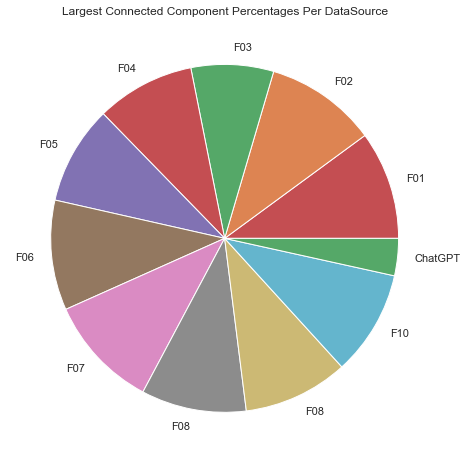

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# use a color palette with 11 unique colors
palette = sns.color_palette(n_colors=11)

# manually set colors for 'A' and 'K'
palette[0] = 'r'
palette[-1] = 'g'

# create a pie chart with unique colors
plt.pie(df_cc['CCPercent'], labels=df_cc['DataSource'], colors=palette)
plt.title('Largest Connected Component Percentages Per DataSource')

# save the figure to a file
plt.savefig('pie_chart.png', dpi=600, bbox_inches='tight')

plt.show()

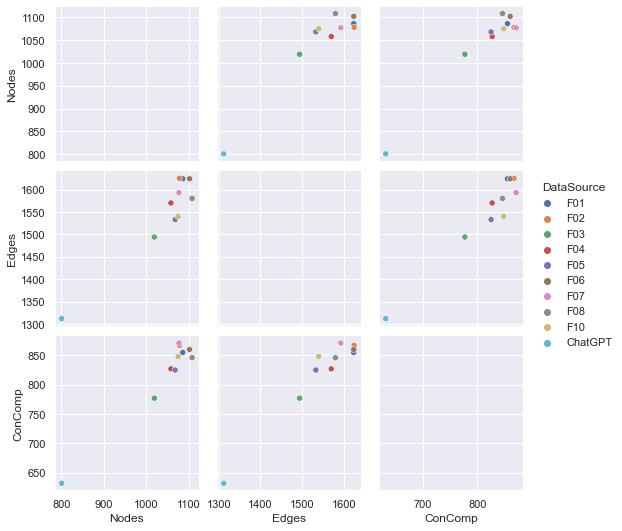

In [88]:
# create the pair plot
sns.pairplot(df_cc, hue="DataSource")

# save the plot to a file
plt.savefig("pairplot-dpi600.png", dpi=1600)

In [86]:
# list(giant)[:10]